In [1]:
import logging

import torch
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader
from torchvision.models import (
    # ======================= ResNet ======================= #
    resnet18, ResNet18_Weights,
    resnet34, ResNet34_Weights,
    resnet50, ResNet50_Weights,
    resnet101, ResNet101_Weights,
    resnet152, ResNet152_Weights,
    # ===================== Mobile Net ===================== #
    mobilenet_v3_small, MobileNet_V3_Small_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
    # ==================== EfficientNet ==================== #
    efficientnet_b0, EfficientNet_B0_Weights,
    efficientnet_b1, EfficientNet_B1_Weights,
    efficientnet_v2_s, EfficientNet_V2_S_Weights,
    efficientnet_v2_m, EfficientNet_V2_M_Weights,
    efficientnet_v2_l, EfficientNet_V2_L_Weights,
    # ================= Vision Transformer ================= #
    vit_b_16, ViT_B_16_Weights,
    vit_b_32, ViT_B_32_Weights,
    vit_l_16, ViT_L_16_Weights,
    vit_l_32, ViT_L_32_Weights,
    vit_h_14, ViT_H_14_Weights,
)

from data_loader import get_wildfire_datasets

2025-01-14 11:05:24,896 [INFO] Data saved to: /home/zliu/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1


In [4]:
BATCHSIZE = 64

# logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# Define models for feature extraction
MODELS = {
    # name: [model, param_size]
    # =============================================================== ResNet =============================================================== #
    # ResNet18 89.17%
    "resnet18": [resnet18(weights=ResNet18_Weights.DEFAULT), sum(p.numel() for p in resnet18(weights=ResNet18_Weights.DEFAULT).parameters())],
    # ResNet34
    "resnet34": [resnet34(weights=ResNet34_Weights.DEFAULT), sum(p.numel() for p in resnet34(weights=ResNet34_Weights.DEFAULT).parameters())],
    # ResNet50 88.83%
    "resnet50": [resnet50(weights=ResNet50_Weights.DEFAULT), sum(p.numel() for p in resnet50(weights=ResNet50_Weights.DEFAULT).parameters())],
    # ResNet101 89.19%
    "resnet101": [resnet101(weights=ResNet101_Weights.DEFAULT), sum(p.numel() for p in resnet101(weights=ResNet101_Weights.DEFAULT).parameters())],
    # ResNet152 89.56%
    "resnet152": [resnet152(weights=ResNet152_Weights.DEFAULT), sum(p.numel() for p in resnet152(weights=ResNet152_Weights.DEFAULT).parameters())],
    # # ============================================================= Mobile Net ============================================================= #
    # # MobileNet V3 Small 81.02%
    # "mobilenetv3small": [mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT), sum(p.numel() for p in mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).parameters())],
    # # MobileNet V3 Large 89.90%
    # "mobilenetv3large": [mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT), sum(p.numel() for p in mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT).parameters())],
    # # ============================================================ EfficientNet ============================================================ #
    # # EfficientNet b0 90.76%
    # "efficientnet_b0": [efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT), sum(p.numel() for p in efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).parameters())],
    # # EfficientNet b1 88.62%
    # "efficientnet_b1": [efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT), sum(p.numel() for p in efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT).parameters())],
    # # EfficientNet v2 Small 85.71%
    # "efficientnet_v2_s": [efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT), sum(p.numel() for p in efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT).parameters())],
    # # EfficientNet v2 Medium 80.71%
    # "efficientnet_v2_m": [efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT), sum(p.numel() for p in efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT).parameters())],
    # # EfficientNet v2 Large 84.63%
    # "efficientnet_v2_l": [efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT), sum(p.numel() for p in efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT).parameters())],
    # # ========================================================= Vision Transformer ========================================================= #
    # # ViT B-16 87%
    # "vit_b_16": [vit_b_16(weights=ViT_B_16_Weights.DEFAULT), sum(p.numel() for p in vit_b_16(weights=ViT_B_16_Weights.DEFAULT).parameters())],
    # # ViT B-32 86%
    # "vit_b_32": [vit_b_32(weights=ViT_B_32_Weights.DEFAULT), sum(p.numel() for p in vit_b_32(weights=ViT_B_32_Weights.DEFAULT).parameters())],
}

# Clear cuda mem and cache
torch.cuda.empty_cache()

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/zliu/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 27.8MB/s]


device(type='cpu')

In [46]:
# Extract features function
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            images, _ = batch
            images = images.to(device)
            # with torch.autocast("cuda", dtype=torch.float16, enabled=True, cache_enabled=True):
            #     feats = model(images).cpu()  # Move features to CPU immediately
            feats = model(images).cpu()
            features.append(feats)
    return torch.cat(features)
# Evaluation function
def evaluate_model(kmeans, model, loader, device, true_labels):
    features = extract_features(model, loader, device)
    predicted_labels = kmeans.predict(features.cpu())

    # Map cluster labels to true labels
    cluster_to_class = {}
    for cluster in range(2):
        cluster_indices = predicted_labels == cluster
        majority_class = true_labels[cluster_indices].mean().round()
        cluster_to_class[cluster] = majority_class

    mapped_predictions = np.array([cluster_to_class[label] for label in predicted_labels])

    accuracy = accuracy_score(true_labels, mapped_predictions)
    report = classification_report(true_labels, mapped_predictions, target_names=["No Wildfire", "Wildfire"])
    cm = confusion_matrix(true_labels, mapped_predictions)

    return accuracy, report, cm

In [20]:
# Load datasets
train_ds, test_ds, valid_ds = get_wildfire_datasets()
train_loader = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCHSIZE, shuffle=False)
test_labels = np.array([label for _, label in tqdm(test_ds, desc="Extracting test labels")])

2025-01-13 17:23:29,800 [INFO] Train: 30250 images, 30250 labels
2025-01-13 17:23:29,800 [INFO] Test: 6300 images, 6300 labels
2025-01-13 17:23:29,801 [INFO] Valid: 6300 images, 6300 labels


Extracting test labels:   0%|          | 0/6300 [00:00<?, ?it/s]

Premature end of JPEG file


In [47]:
# estimate the cuda memory usage by batch size and model sizes and image size
for model_name, model_ls in MODELS.items():
    model = model_ls[0]
    cuda_available_memory = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)
    estimated_memory = sum(p.numel() for p in model.parameters()) * 4 / 1024 ** 2  # in MB
    logging.info(f"Estimated model memory: {estimated_memory:.2f} MB")
    if estimated_memory > cuda_available_memory:
        raise MemoryError("Not enough GPU memory for this model.")

2025-01-13 17:58:16,084 [INFO] Estimated model memory: 20.17 MB


In [48]:
# models setup for feature extraction with tqdm
# Prepare models and extract features
model_results = {}
for model_name, model_ls in tqdm(MODELS.items(), desc="Processing models"):
    model = model_ls[0]
    logging.info(f"Setting up {model_name}...")
    if model_name == "resnet18":
        model.fc = torch.nn.Identity()
    elif model_name in ["mobilenetv3", "efficientnet"]:
        model.classifier = torch.nn.Identity()
    elif model_name == "vit_b_16":
        model.heads.head = torch.nn.Identity()

    model = model.to(device)

    # Extract features
    logging.info(f"Extracting features with {model_name}...")
    features = extract_features(model, train_loader, device)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
    model_results[model_name] = {
        "model": model,
        "kmeans": kmeans,
        "train_features": features,
    }

    # Clear cuda memory
    model = model.to(torch.device("cpu"))
    torch.cuda.empty_cache()

Processing models:   0%|          | 0/1 [00:00<?, ?it/s]

2025-01-13 17:58:17,523 [INFO] Setting up efficientnet_b0...
2025-01-13 17:58:17,549 [INFO] Extracting features with efficientnet_b0...


Extracting features:   0%|          | 0/473 [00:00<?, ?it/s]

Premature end of JPEG file


2025-01-13 17:59:49,852 [INFO] Evaluating efficientnet_b0...


Extracting features:   0%|          | 0/99 [00:00<?, ?it/s]

Premature end of JPEG file
2025-01-13 18:00:08,785 [INFO] efficientnet_b0 accuracy: 90.76%
2025-01-13 18:00:08,785 [INFO] efficientnet_b0 classification report:
              precision    recall  f1-score   support

 No Wildfire       0.89      0.91      0.90      2820
    Wildfire       0.92      0.91      0.92      3480

    accuracy                           0.91      6300
   macro avg       0.91      0.91      0.91      6300
weighted avg       0.91      0.91      0.91      6300



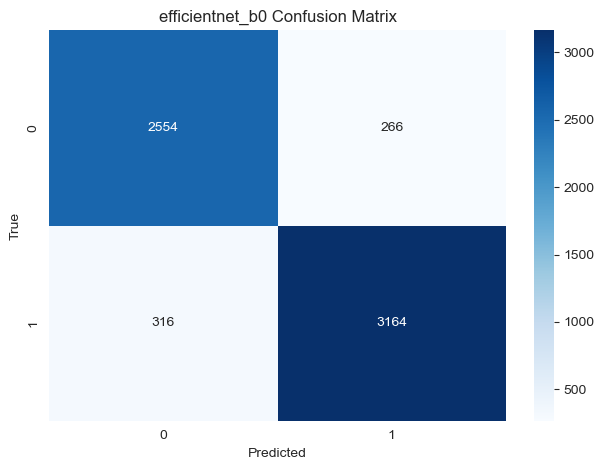

In [49]:
# Evaluate all models
for model_name, data in model_results.items():
    logging.info(f"Evaluating {model_name}...")
    kmeans = data["kmeans"]
    model = data["model"]
    model = model.to(device)

    accuracy, report, cm = evaluate_model(kmeans, model, test_loader, device, test_labels)

    print(f"{model_name} {accuracy * 100:.2f}%")
    # resnet18(weights=ResNet18_Weights.DEFAULT)
    print(f"{MODELS[model_name][0]}")
    print(f"{model_name} classification report:\n{report}")

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

## ResNet
```txt
resnet18(weights=ResNet18_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.89      0.86      0.88      2820
    Wildfire       0.89      0.92      0.90      3480

    accuracy                           0.89      6300
   macro avg       0.89      0.89      0.89      6300
weighted avg       0.89      0.89      0.89      6300
```
```txt
resnet50(weights=ResNet50_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.86      0.90      0.88      2820
    Wildfire       0.92      0.88      0.90      3480

    accuracy                           0.89      6300
   macro avg       0.89      0.89      0.89      6300
weighted avg       0.89      0.89      0.89      6300
```
```txt
resnet101(weights=ResNet101_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.87      0.89      0.88      2820
    Wildfire       0.91      0.89      0.90      3480

    accuracy                           0.89      6300
   macro avg       0.89      0.89      0.89      6300
weighted avg       0.89      0.89      0.89      6300
```
```txt
resnet152(weights=ResNet152_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.87      0.91      0.89      2820
    Wildfire       0.92      0.89      0.90      3480

    accuracy                           0.90      6300
   macro avg       0.89      0.90      0.89      6300
weighted avg       0.90      0.90      0.90      6300
```

## MobileNetv3
```txt
mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.88      0.66      0.76      2820
    Wildfire       0.77      0.93      0.84      3480

    accuracy                           0.81      6300
   macro avg       0.83      0.80      0.80      6300
weighted avg       0.82      0.81      0.81      6300
```
```txt
mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.88      0.90      0.89      2820
    Wildfire       0.92      0.90      0.91      3480

    accuracy                           0.90      6300
   macro avg       0.90      0.90      0.90      6300
weighted avg       0.90      0.90      0.90      6300
```
## EfficientNet
```txt
efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.89      0.91      0.90      2820
    Wildfire       0.92      0.91      0.92      3480

    accuracy                           0.91      6300
   macro avg       0.91      0.91      0.91      6300
weighted avg       0.91      0.91      0.91      6300
```
```txt
efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.86      0.89      0.87      2820
    Wildfire       0.91      0.89      0.90      3480

    accuracy                           0.89      6300
   macro avg       0.88      0.89      0.89      6300
weighted avg       0.89      0.89      0.89      6300
```
```txt
efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.80      0.91      0.85      2820
    Wildfire       0.92      0.81      0.86      3480

    accuracy                           0.86      6300
   macro avg       0.86      0.86      0.86      6300
weighted avg       0.86      0.86      0.86      6300
```
```txt
efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.72      0.93      0.81      2820
    Wildfire       0.92      0.71      0.80      3480

    accuracy                           0.81      6300
   macro avg       0.82      0.82      0.81      6300
weighted avg       0.83      0.81      0.81      6300
```
```txt
efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.81      0.86      0.83      2820
    Wildfire       0.88      0.84      0.86      3480

    accuracy                           0.85      6300
   macro avg       0.84      0.85      0.85      6300
weighted avg       0.85      0.85      0.85      6300
```
## ViT
```txt
vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.92      0.82      0.87      2820
    Wildfire       0.87      0.94      0.90      3480

    accuracy                           0.89      6300
   macro avg       0.89      0.88      0.89      6300
weighted avg       0.89      0.89      0.89      6300
```
```txt
vit_b_32(weights=ViT_B_32_Weights.DEFAULT)
              precision    recall  f1-score   support
 No Wildfire       0.81      0.91      0.85      2820
    Wildfire       0.92      0.82      0.87      3480

    accuracy                           0.86      6300
   macro avg       0.86      0.87      0.86      6300
weighted avg       0.87      0.86      0.86      6300
```